<a href="https://colab.research.google.com/github/whyeon92/ESAA_YB/blob/Code_Study/ESAA_HW0510.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌5-6. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

이전의 선형 모델의 비용 함수는 RSS를 최소화 하는 것만 고려하다보니 지나치게 학습 데이터에 맞추게 되고, 회귀 계수가 커졌다. 이런 변동성이 오히려 심해지면 테스트 데이터에선 과적합으로 인해 예측 성능이 저하되기가 쉽다.  
⇒ **RSS 최소화시키고 회귀계수 커지지 않는 것이 균형을 이뤄야함!!**

위와 같은 논리에 따라서 보면, 비용함수의 목표는 다음을 만족시키는 W를 찾는 것과 같다.  

$Min(RSS(W) +alpha*{\lVert W \rVert}_2^2)$  
  
$\alpha$ : 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터

## 릿지 회귀

In [2]:
#앞에서 사용한 데이터 불러오기
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

#보스턴 데이터 가져오기!
data_url = "http://lib.stat.cmu.edu/datasets/boston"

raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

# feature name이 없으므로 따로 지정해줘야 함.

feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX' ,'PTRATIO', 'B' ,'LSTAT', 'PRICE']

bostonDF = pd.DataFrame(boston, columns=feature_names)

print('Boston 데이터 세트 크기:', bostonDF.shape)

bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 156)

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

#alpha = 10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores: ', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE: 5.518


In [5]:
#릿지에 사용된 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

#alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함
for alpha in alphas:
  ridge = Ridge(alpha = alpha)

  #cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
  rmse_scores = np.sqrt(-1 * neg_mse_scores)
  print('alpha {0}일 때 5 folds의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE: 5.518
alpha 0.1일 때 5 folds의 평균 RMSE: 5.518
alpha 1일 때 5 folds의 평균 RMSE: 5.518
alpha 10일 때 5 folds의 평균 RMSE: 5.518
alpha 100일 때 5 folds의 평균 RMSE: 5.518


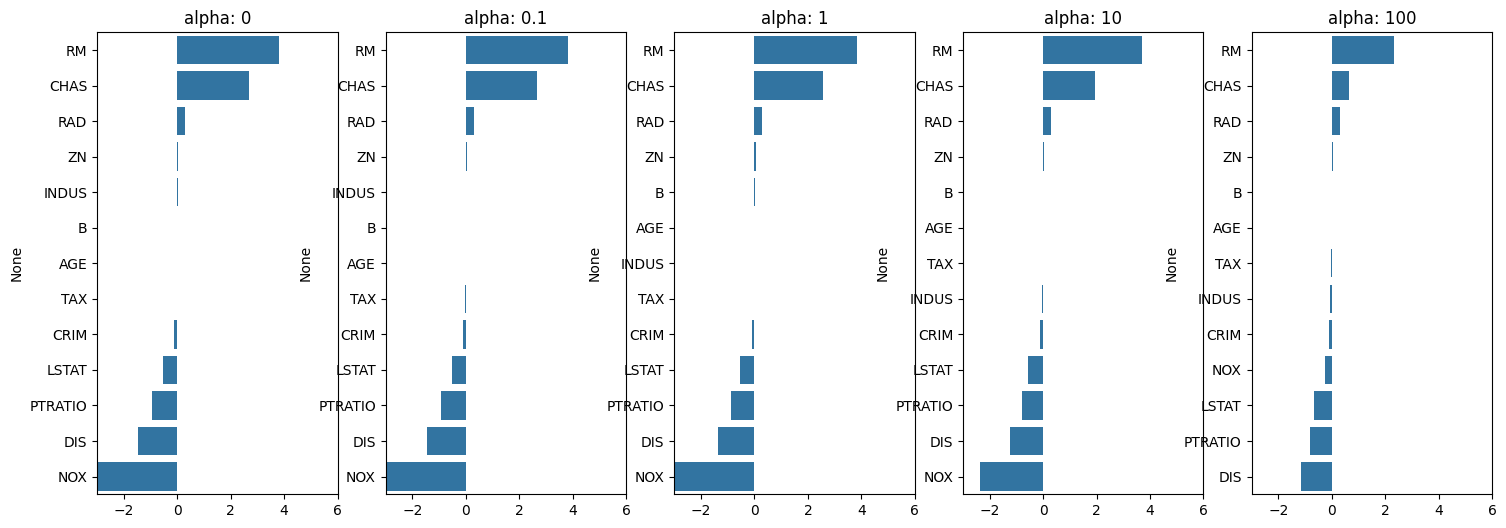

In [6]:
#각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize = (18, 6), nrows = 1, ncols = 5)
#각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

#alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_data, y_target)
  #alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
  coeff = pd.Series(data = ridge.coef_, index = X_data.columns)
  colname = 'alpha: ' + str(alpha)
  coeff_df[colname] = coeff
  #막대 그래프로 각 dlpha 값에서의 회귀 계수를 시각화, 회귀 계수값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending = False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3, 6)
  sns.barplot(x= coeff.values, y = coeff.index, ax = axs[pos])

#for문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

In [7]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha: ' + str(ridge_alphas[0])
coeff_df.sort_values(by = sort_column, ascending = False)

,alpha: 0,alpha: 0.1,alpha: 1,alpha: 10,alpha: 100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


[릿지(Ridge)]

위에서 간략히 봤듯이, 릿지는 L2 규제(상대적으로 큰 회귀 계수 값의 예측 영향도를 감소시키기 위해 회귀 계수값을 더 작게 만드는 규제 모델)를 통해 페널티를 부여한다.

## 라쏘 회귀

In [8]:
from sklearn.linear_model import Lasso, ElasticNet

#alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        #cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

        model.fit(X_data_n , y_target_n)
        if return_coeff:
            #alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가
            coeff = pd.Series(data=model.coef_ , index=X_data_n.columns )
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff

    return coeff_df
#end of get_linear_regre_eval

In [9]:
#라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


In [10]:
#반환된 coeff_lasso_df를 첫번째 칼럼순으로 내림차순 정렬하여 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending = False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


In [11]:
#엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
#l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [12]:
#반환된 coeff_elastic_df를 첫번째 칼럼순으로 내림차순 정렬하여 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

#method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
#p_degree는 다향식 특성을 추가할 때 적용, p_degree는 2이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

    return scaled_data

In [14]:
#Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]

#5개 방식으로 변환, 먼더 원본 그대로, 표준정규 분포, 표준정규 분포+다항식 특성
#최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2),
               ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False, return_coeff=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330 

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421 

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634 

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635 

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538 

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴

[라쏘(Lasso)]

앞서 본 릿지는 0이 되게 만들지 않았지만 라쏘는 회귀 계수가 0이 되게 만드는 L1규제의 회귀이다.  
  
[엘라스틱넷(Elastic Net)]

엘라스틱 넷은 L1, L2규제를 결합한 회귀로, 라쏘 회귀가 급격하게 회귀 계수의 값을 변동시킬 수 있는 단점을 보완하기 위해 L2 규제를 라쏘 회귀에 추가한 것이다. 물론, 당연히 이렇게 두개를 같이 쓰니까 성능은 더 좋은 편이긴 하나, 수행시간이 상대적으로 오래 걸리기도 한다.

# 📌5-7. 로지스틱 회귀

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#StandardScaler()로 평균이 0, 분산 1로 데이터 분포로 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train , X_test, y_train , y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행.
# solver 인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc:{0:.3f}'.format(roc_auc_score(y_test , lr_preds)))

accuracy: 0.977
roc_auc:0.972


In [18]:
from sklearn.model_selection import GridSearchCV

params={'solver':['liblinear', 'lbfgs'],
        'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3 )
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

[로지스틱 회귀]  
: 선형 회귀 방식을 분류에 적용한 알고리즘
선형함수의 회귀 최적선을 찾는 게 아닌, 시그모이드 함수 최적선을 찾음.